In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
data_path = r"D:\project1\pythonProject\Multi-Branch Energy Forecasting\dataset"

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

D:\project1\pythonProject\Multi-Branch Energy Forecasting\dataset\dataset.csv


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, LSTM, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. 读取数据
data = pd.read_csv("D:\\project1\\pythonProject\\Multi-Branch Energy Forecasting\\dataset\\dataset.csv")

print("names of columns：", data.columns)

names of columns： Index(['Year', 'Month', 'Sector', 'Hydroelectric Power', 'Geothermal Energy',
       'Solar Energy', 'Wind Energy', 'Wood Energy', 'Waste Energy',
       'Fuel Ethanol, Excluding Denaturant', 'Biomass Losses and Co-products',
       'Biomass Energy', 'Total Renewable Energy', 'Renewable Diesel Fuel',
       'Other Biofuels', 'Conventional Hydroelectric Power', 'Biodiesel'],
      dtype='object')


In [6]:
# Data preprocessing
# If the dataset includes date-related information, convert it to datetime format and sort it.
# If not, skip this step (previous error indicated that the dataset doesn't have a 'date' column)
# For example: if there is a 'year' column, you can consider:
# data['year'] = pd.to_datetime(data['year'], format='%Y')
# data.sort_values('year', inplace=True)

# Determine the target variable: if there is a 'consumption' column, use it; otherwise, use the last column by default
if 'consumption' in data.columns:
    target_col = 'consumption'
else:
    target_col = data.columns[-1]

# Separate the target from the features
target = data[target_col]
features = data.drop(columns=[target_col])

# If there are non-numeric features, we select only numeric ones for simplicity
features = features.select_dtypes(include=[np.number])

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target.values, test_size=0.2, random_state=42)

# If the data has time sequence characteristics, and each sample represents one time step,
# expand the dimensions to shape [samples, time steps, features]
# Here we assume each sample is a single time step
X_train = np.expand_dims(X_train, axis=1)  # shape: (samples, timesteps, features)
X_test = np.expand_dims(X_test, axis=1)

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
input_layer = Input(shape=input_shape)

# A ： CNN 
x_a = Conv1D(filters=32, kernel_size=1, activation='relu')(input_layer)
x_a = Flatten()(x_a)

# B ： LSTM 
x_b = LSTM(32, return_sequences=False)(input_layer)

# C ：
x_c = Flatten()(input_layer)
x_c = Dense(32, activation='relu')(x_c)

# combine 3 branches
combined = Concatenate()([x_a, x_b, x_c])
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.2)(combined)
output = Dense(1, activation='linear')(combined)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Print the model structure
model.summary()
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)
# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Test MSE:", mse)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 32)     │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 15)        │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │      6,144 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        512 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ lstm[0][0],       │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,441 (52.50 KB)

 Trainable params: 13,441 (52.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.9346 - val_loss: 2.8461
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3084 - val_loss: 1.3899
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5181 - val_loss: 0.9207
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0783 - val_loss: 0.7334
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7812 - val_loss: 0.6842
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8252 - val_loss: 0.6978
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7479 - val_loss: 0.6850
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6111 - val_loss: 0.7104
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5661 - val_loss: 0.6702
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7405 - val_loss: 0.6633
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5980 - val_loss: 0.6003
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5366 - val_l

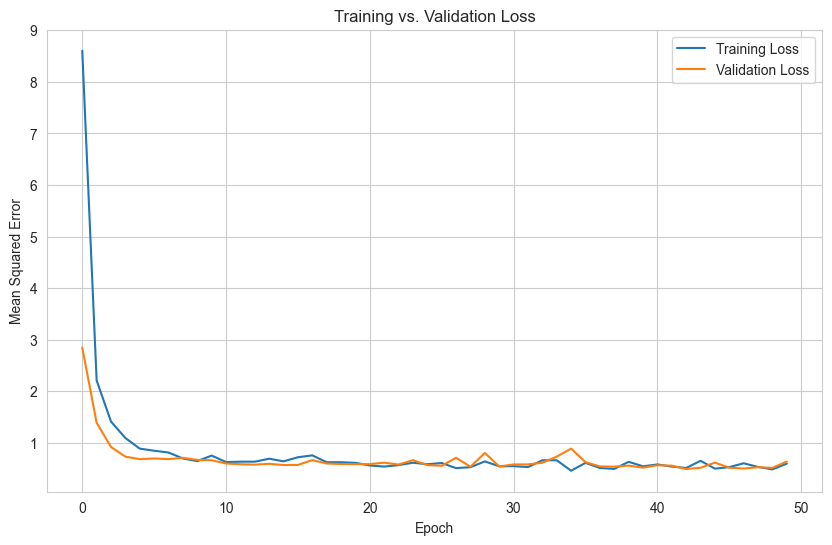

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step


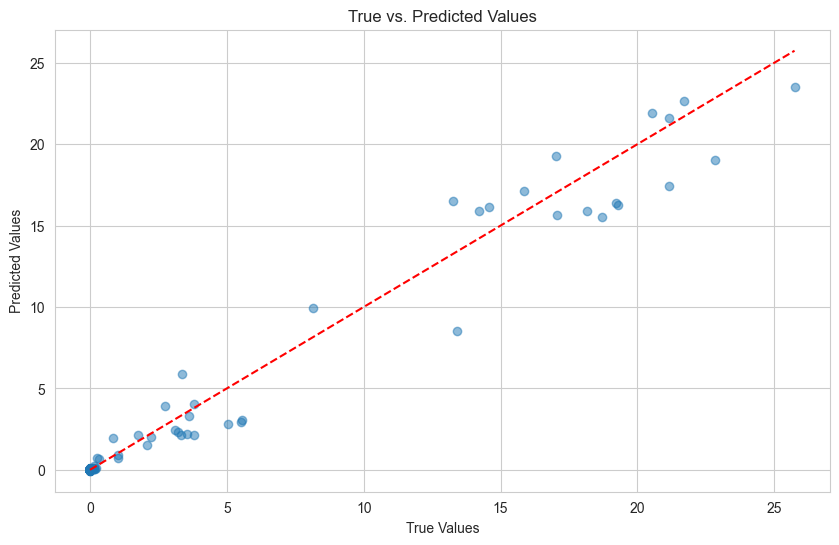

In [23]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# 7.1 Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# 7.2 Plot the scatter plot comparing true values and predictions
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
# Plot the y=x reference line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

# 7.3 Visualize the model architecture
# plot_model(model, to_file='model.png', show_shapes=True)
# display(Image(filename='model.png'))

In [22]:
#Ablation Study
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, LSTM, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Define the full model with all three branches (A: CNN, B: LSTM, C: Dense)
def build_full_model(input_shape):
    input_layer = Input(shape=input_shape)
    
    # Branch A: CNN
    x_a = Conv1D(filters=32, kernel_size=1, activation='relu')(input_layer)
    x_a = Flatten()(x_a)
    
    # Branch B: LSTM
    x_b = LSTM(32, return_sequences=False)(input_layer)
    
    # Branch C: Dense branch (processing flattened input)
    x_c = Flatten()(input_layer)
    x_c = Dense(32, activation='relu')(x_c)
    
    # Concatenate all branches
    combined = Concatenate()([x_a, x_b, x_c])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.2)(combined)
    output = Dense(1, activation='linear')(combined)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Ablation variant 1: Remove Branch A (CNN)
def build_model_without_A(input_shape):
    input_layer = Input(shape=input_shape)
    
    # Only include Branch B: LSTM and Branch C: Dense
    x_b = LSTM(32, return_sequences=False)(input_layer)
    x_c = Flatten()(input_layer)
    x_c = Dense(32, activation='relu')(x_c)
    
    combined = Concatenate()([x_b, x_c])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.2)(combined)
    output = Dense(1, activation='linear')(combined)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Ablation variant 2: Remove Branch B (LSTM)
def build_model_without_B(input_shape):
    input_layer = Input(shape=input_shape)
    
    # Only include Branch A: CNN and Branch C: Dense
    x_a = Conv1D(filters=32, kernel_size=1, activation='relu')(input_layer)
    x_a = Flatten()(x_a)
    x_c = Flatten()(input_layer)
    x_c = Dense(32, activation='relu')(x_c)
    
    combined = Concatenate()([x_a, x_c])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.2)(combined)
    output = Dense(1, activation='linear')(combined)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Ablation variant 3: Remove Branch C (Dense)
def build_model_without_C(input_shape):
    input_layer = Input(shape=input_shape)
    
    # Only include Branch A: CNN and Branch B: LSTM
    x_a = Conv1D(filters=32, kernel_size=1, activation='relu')(input_layer)
    x_a = Flatten()(x_a)
    x_b = LSTM(32, return_sequences=False)(input_layer)
    
    combined = Concatenate()([x_a, x_b])
    combined = Dense(64, activation='relu')(combined)
    combined = Dropout(0.2)(combined)
    output = Dense(1, activation='linear')(combined)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Assuming X_train, y_train, X_test, y_test are already defined and preprocessed.
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the four model variants
full_model      = build_full_model(input_shape)
model_without_A = build_model_without_A(input_shape)
model_without_B = build_model_without_B(input_shape)
model_without_C = build_model_without_C(input_shape)

# Train each model
print("Training full model...")
history_full = full_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
mse_full = full_model.evaluate(X_test, y_test, verbose=0)

print("Training model without Branch A (CNN)...")
history_noA = model_without_A.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
mse_noA = model_without_A.evaluate(X_test, y_test, verbose=0)

print("Training model without Branch B (LSTM)...")
history_noB = model_without_B.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
mse_noB = model_without_B.evaluate(X_test, y_test, verbose=0)

print("Training model without Branch C (Dense)...")
history_noC = model_without_C.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
mse_noC = model_without_C.evaluate(X_test, y_test, verbose=0)

# Print test MSE for each model variant
print("\nAblation Study Results:")
print("Full model Test MSE:             {:.4f}".format(mse_full))
print("Model without Branch A (CNN) MSE:  {:.4f}".format(mse_noA))
print("Model without Branch B (LSTM) MSE: {:.4f}".format(mse_noB))
print("Model without Branch C (Dense) MSE:{:.4f}".format(mse_noC))

Training full model...
Training model without Branch A (CNN)...
Training model without Branch B (LSTM)...
Training model without Branch C (Dense)...

Ablation Study Results:
Full model Test MSE:             0.2091
Model without Branch A (CNN) MSE:  0.2293
Model without Branch B (LSTM) MSE: 0.2833
Model without Branch C (Dense) MSE:0.2725
